In [11]:
import pandas as pd



import gensim
from gensim import corpora
import pyLDAvis
import pyLDAvis.gensim_models
from gensim.models import LdaModel

In [21]:
data = pd.read_csv('data/monthly_best_1000_cleaned.csv', sep=";")
data.set_index('Id', inplace=True)

## Recherche des paramètres optimaux

Nous allons chercher à déterminer les paramètres optimaux du modèle LDA, qui nous permettra 

In [22]:
no_below_values = [2, 5, 10]        # Fréquence minimale dans les documents
no_above_values = [0.5, 0.3, 0.1]   # Fréquence maximale (en fraction) dans les documents
num_topics_range = [10, 30, 50, 100, 150]  # Tester les nombres de topics de 5 à 15

results = []


In [23]:

tokens = data['Body'].str.split(',')

from gensim.models.coherencemodel import CoherenceModel

for no_below in no_below_values:
    # Parcourir les valeurs de no_above
    for no_above in no_above_values:
        print(f"\nFiltrage avec no_below={no_below}, no_above={no_above}")
        
        # Créer une nouvelle instance du dictionnaire pour chaque combinaison
        dictionary = corpora.Dictionary(tokens)
        original_token_count = len(dictionary)
        
        # Appliquer le filtrage
        dictionary.filter_extremes(no_below=no_below, no_above=no_above)
        filtered_token_count = len(dictionary)
        print(f"Nombre de tokens avant filtrage : {original_token_count}")
        print(f"Nombre de tokens après filtrage : {filtered_token_count}")
        
        # Créer le corpus
        corpus = [dictionary.doc2bow(text) for text in tokens]
        
        # Parcourir les valeurs de num_topics
        for num_topics in num_topics_range:
            print(f"Entraînement du modèle LDA avec {num_topics} topics...")
            lda_model = LdaModel(corpus=corpus,
                                 id2word=dictionary,
                                 num_topics=num_topics,
                                 random_state=42,
                                 update_every=1,
                                 chunksize=100,
                                 passes=10,
                                 alpha='auto',
                                 per_word_topics=True)
            
            # Calculer la cohérence du modèle
            coherence_model_lda = CoherenceModel(model=lda_model, texts=tokens, dictionary=dictionary, coherence='c_v')
            coherence_lda = coherence_model_lda.get_coherence()
            
            # Enregistrer les résultats
            results.append({
                'no_below': no_below,
                'no_above': no_above,
                'num_topics': num_topics,
                'coherence': coherence_lda
            })


Filtrage avec no_below=2, no_above=0.5
Nombre de tokens avant filtrage : 161136
Nombre de tokens après filtrage : 47568
Entraînement du modèle LDA avec 10 topics...
Entraînement du modèle LDA avec 30 topics...
Entraînement du modèle LDA avec 50 topics...
Entraînement du modèle LDA avec 100 topics...
Entraînement du modèle LDA avec 150 topics...

Filtrage avec no_below=2, no_above=0.3
Nombre de tokens avant filtrage : 161136
Nombre de tokens après filtrage : 47562
Entraînement du modèle LDA avec 10 topics...
Entraînement du modèle LDA avec 30 topics...
Entraînement du modèle LDA avec 50 topics...
Entraînement du modèle LDA avec 100 topics...
Entraînement du modèle LDA avec 150 topics...

Filtrage avec no_below=2, no_above=0.1
Nombre de tokens avant filtrage : 161136
Nombre de tokens après filtrage : 47518
Entraînement du modèle LDA avec 10 topics...
Entraînement du modèle LDA avec 30 topics...
Entraînement du modèle LDA avec 50 topics...
Entraînement du modèle LDA avec 100 topics...
En

In [24]:

results_df = pd.DataFrame(results)
top_results = results_df.sort_values(by='coherence', ascending=False)
print("\nTop 10 des configurations par score de cohérence :")
print(top_results.head(10))


Top 10 des configurations par score de cohérence :
    no_below  no_above  num_topics  coherence
29         5       0.1         150   0.587322
15         5       0.5          10   0.551706
0          2       0.5          10   0.551660
28         5       0.1         100   0.551447
5          2       0.3          10   0.547366
39        10       0.3         150   0.542663
44        10       0.1         150   0.538382
30        10       0.5          10   0.531620
34        10       0.5         150   0.527704
35        10       0.3          10   0.523631


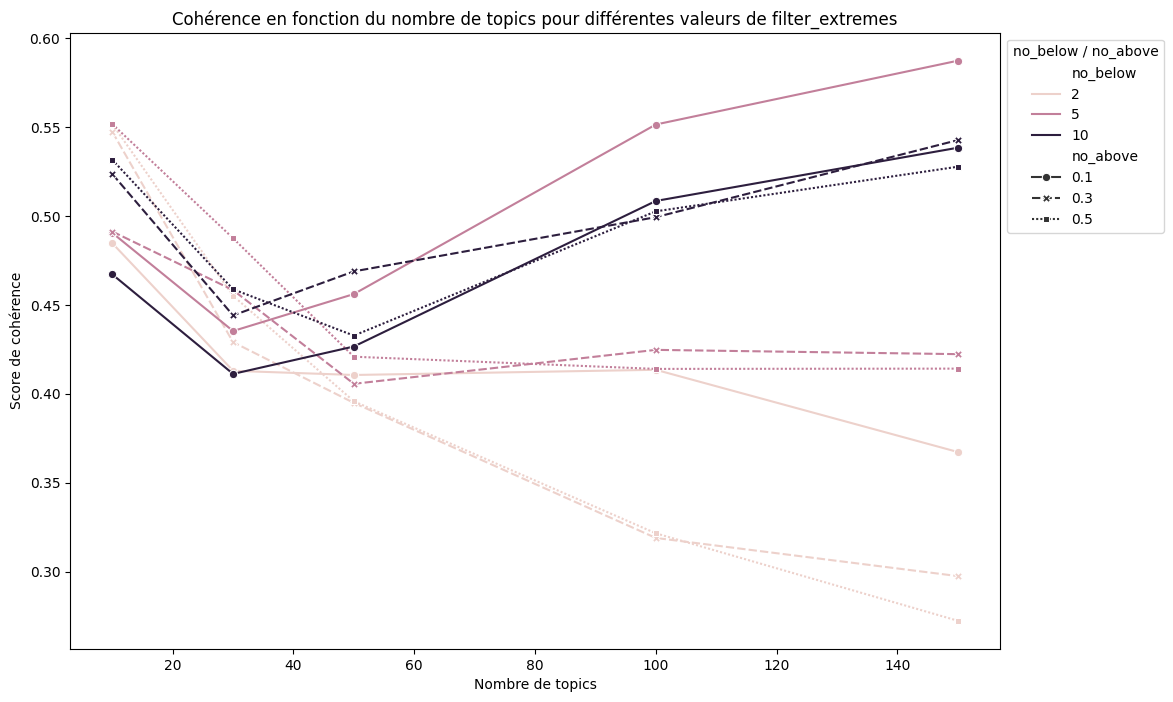

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.lineplot(data=results_df, x='num_topics', y='coherence', hue='no_below', style='no_above', markers=True)
plt.title('Cohérence en fonction du nombre de topics pour différentes valeurs de filter_extremes')
plt.xlabel('Nombre de topics')
plt.ylabel('Score de cohérence')
plt.legend(title='no_below / no_above', loc='best', bbox_to_anchor=(1, 1))
plt.show()

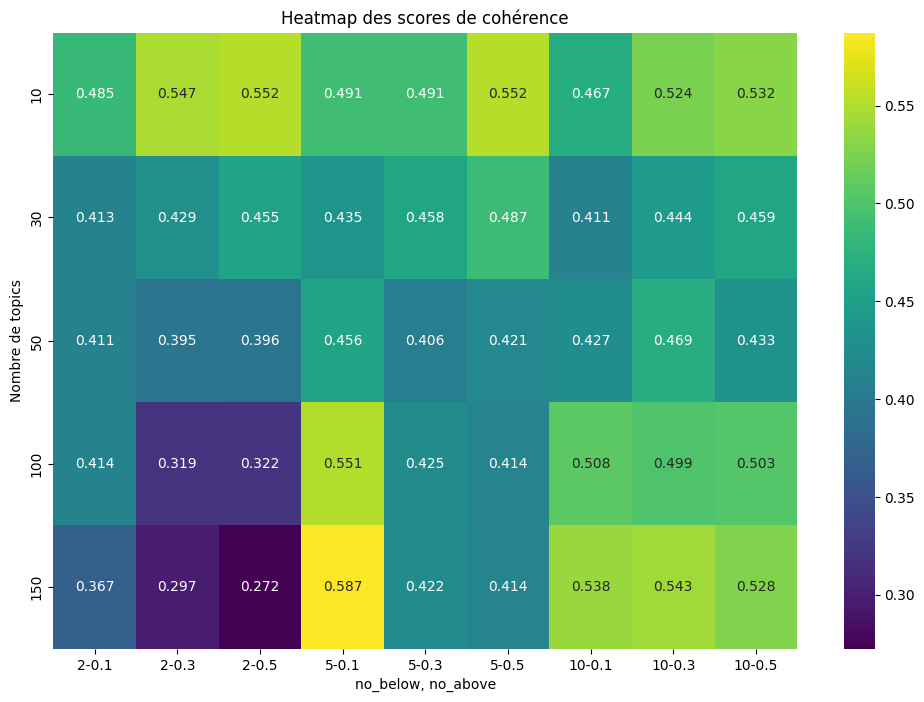

In [26]:
# Pivot du DataFrame pour créer une matrice de cohérence
pivot_table = results_df.pivot_table(values='coherence', index='num_topics', columns=['no_below', 'no_above'])

# Tracer la heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap='viridis')
plt.title('Heatmap des scores de cohérence')
plt.xlabel('no_below, no_above')
plt.ylabel('Nombre de topics')
plt.show()

In [27]:
best_config = top_results.iloc[0]
print(f"\nMeilleure configuration :\n{best_config}")


Meilleure configuration :
no_below        5.000000
no_above        0.100000
num_topics    150.000000
coherence       0.587322
Name: 29, dtype: float64


In [28]:
# Récupérer les paramètres optimaux
optimal_no_below = best_config['no_below']
optimal_no_above = best_config['no_above']
optimal_num_topics = best_config['num_topics']

print(f"\nEntraînement du modèle LDA final avec les paramètres optimaux...")
dictionary = corpora.Dictionary(tokens)
dictionary.filter_extremes(no_below=optimal_no_below, no_above=optimal_no_above)
corpus = [dictionary.doc2bow(text) for text in tokens]

lda_model_optimal = LdaModel(corpus=corpus,
                             id2word=dictionary,
                             num_topics=int(optimal_num_topics),
                             random_state=42,
                             update_every=1,
                             chunksize=100,
                             passes=10,
                             alpha='auto',
                             per_word_topics=True)


Entraînement du modèle LDA final avec les paramètres optimaux...


In [29]:
# Afficher les topics
for idx, topic in lda_model_optimal.print_topics(-1):
    print(f"Topic {idx+1} : {topic}\n")

Topic 1 : 0.000*"appleboy" + 0.000*"mkdirs" + 0.000*"diesel" + 0.000*"assemblerelease" + 0.000*"outputoptions" + 0.000*"zi" + 0.000*"mysqladmin" + 0.000*"givenname" + 0.000*"wsgiapp" + 0.000*"avcapturedevice"

Topic 2 : 0.000*"appleboy" + 0.000*"mkdirs" + 0.000*"diesel" + 0.000*"assemblerelease" + 0.000*"outputoptions" + 0.000*"zi" + 0.000*"mysqladmin" + 0.000*"givenname" + 0.000*"wsgiapp" + 0.000*"avcapturedevice"

Topic 3 : 0.625*"h" + 0.343*"header" + 0.026*"guarantee" + 0.000*"givenname" + 0.000*"libpq" + 0.000*"diesel" + 0.000*"assemblerelease" + 0.000*"outputoptions" + 0.000*"zi" + 0.000*"albumentations"

Topic 4 : 0.469*"r" + 0.278*"l" + 0.074*"width" + 0.064*"center" + 0.050*"layout" + 0.027*"height" + 0.017*"marker" + 0.009*"coordinate" + 0.006*"fig" + 0.003*"mirror"

Topic 5 : 0.326*"start" + 0.186*"point" + 0.104*"float" + 0.057*"ssh" + 0.043*"bash" + 0.032*"union" + 0.031*"exe" + 0.030*"assert" + 0.028*"standalone" + 0.023*"assertion"

Topic 6 : 0.000*"appleboy" + 0.000*"mk

In [30]:
vis = pyLDAvis.gensim_models.prepare(lda_model_optimal, corpus, dictionary, mds='tsne')

In [31]:
pyLDAvis.display(vis)


In [47]:
example_text = "How can I implement a neural network in Python?"

from tags_generator.shared.preprocessing import preprocess_text

tokens = preprocess_text(example_text)
# Transformer en Bag-of-Words
bow_vector = dictionary.doc2bow(tokens)
# Obtenir la distribution des topics pour l'entrée
topic_distribution = lda_model_optimal.get_document_topics(bow_vector, minimum_probability=0)
# Identifier le topic dominant
dominant_topic = max(topic_distribution, key=lambda x: x[1])[0]
# Obtenir les tags suggérés à partir des mots-clés du topic dominant

topic_keywords = {}
topn = 10

for topic_id in range(lda_model_optimal.num_topics):
    words = lda_model_optimal.show_topic(topic_id, topn=topn)
    topic_keywords[topic_id] = [word for word, prob in words]

tags = topic_keywords[dominant_topic]


print("\nTags LDA :")
print(tags)


Tags LDA :
['python', 'site', 'pip', 'permission', 'install', 'catalina', 'installation', 'jupyter', 'venv', 'notebook']
